Remove dominant color

In [4]:
from sklearn.cluster import KMeans
import numpy as np
from PIL import Image

def find_dominant_color(image, k=3):
    # Convert image to numpy array
    img_array = np.array(image)
    # Reshape it to a list of RGB values
    img_vector = img_array.reshape((-1, 3))
    # Run k-means on the pixel colors (fit only on a subsample to speed up)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(img_vector[::50])
    # Get the dominant color
    dominant_color = kmeans.cluster_centers_[np.argmax(np.bincount(kmeans.labels_))]
    # Create a mask for pixels within a certain distance from the dominant color
    distances = np.sqrt(np.sum((img_vector - dominant_color) ** 2, axis=1))
    mask = distances < np.std(distances)
    # Turn the dominant color range to white
    img_vector[mask] = [255, 255, 255]
    result_img_array = img_vector.reshape(img_array.shape)
    # Convert the array back to an image
    result_img = Image.fromarray(result_img_array.astype('uint8'))
    return dominant_color, result_img

In [5]:
img_path = '../images/cropped_scales/fixed/187079676.jpg'
img = Image.open(img_path)

dominant_color, result_img = find_dominant_color(img)

dominant_color

array([208.13534144, 190.87037272, 162.2509681 ])

(-0.5, 3370.5, 5790.5, -0.5)

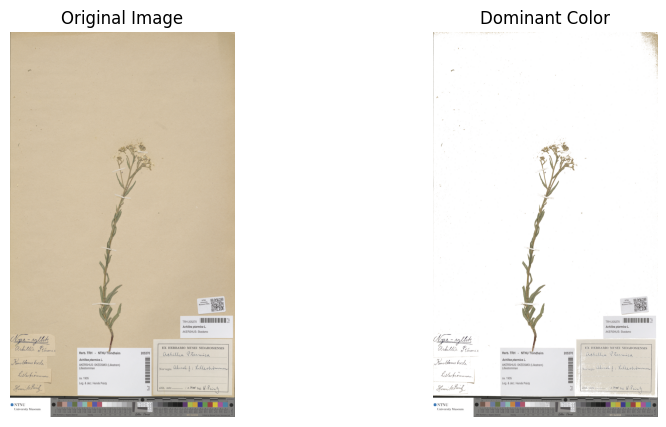

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(result_img)
ax[1].set_title('Dominant Color')
ax[1].axis('off')

Create dataset for classification

In [6]:
import os
import shutil

path1 = '../images/classification/fixed'
path2 = '../images/classification/random'

save_path = '../images/cls_data'

os.makedirs(os.path.join(save_path, 'train', 'fixed'), exist_ok=True)
os.makedirs(os.path.join(save_path, 'train', 'random'), exist_ok=True)
os.makedirs(os.path.join(save_path, 'valid', 'fixed'), exist_ok=True)
os.makedirs(os.path.join(save_path, 'valid', 'random'), exist_ok=True)

fixed = os.listdir(path1)
random = os.listdir(path2)

train = len(fixed) // 100 * 90
train1 = len(random) // 100 * 90

for img_path in fixed[:train]:
    shutil.copy(os.path.join(path1, img_path), os.path.join(save_path, 'train', 'fixed', img_path))

for img_path in fixed[train:]:
    shutil.copy(os.path.join(path1, img_path), os.path.join(save_path, 'valid', 'fixed', img_path))

for img_path in random[:train1]:
    shutil.copy(os.path.join(path2, img_path), os.path.join(save_path, 'train', 'random', img_path))

for img_path in random[train1:]:
    shutil.copy(os.path.join(path2, img_path), os.path.join(save_path, 'valid', 'random', img_path))